In [1]:
#Importing Libraries

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import itertools

In [2]:
#Check if GPU is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#Downloading the data and resizing it such that it can be directly feeded to the model

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class PatchModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(PatchModel, self).__init__()
        self.backbone = resnet18(pretrained=False)
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [5]:
class RelativePatchDataset(Dataset):

    RELATIVE_POSITIONS = {
        (-1, -1): 0,
        (-1, 0): 1,
        (-1, 1): 2,
        (0, -1): 3,
        (0, 0): 4,
        (0, 1): 5,
        (1, -1): 6,
        (1, 0): 7,
        (1, 1): 8}

    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def pad_patch(self, patch):
        padding_h = 32 - patch.shape[1]
        padding_w = 32 - patch.shape[2]
        return F.pad(patch, (padding_w//2, padding_w-padding_w//2, padding_h//2, padding_h-padding_h//2), 'reflect')

    def __getitem__(self, idx):
        image, _ = self.base_dataset[idx]

        h, w = image.shape[1] // 3, image.shape[2] // 3

        start_h = h
        end_h = h * 2
        start_w = w
        end_w = w * 2

        center_patch = image[:, start_h:end_h, start_w:end_w]

        if center_patch.shape[1] != h or center_patch.shape[2] != w:
            center_patch = self.pad_patch(center_patch)

        relative_pos = list(self.RELATIVE_POSITIONS.keys())
        relative_pos.remove((0, 0))
        index = np.random.randint(0, len(relative_pos))
        pos = relative_pos[index]

        start_h += pos[0] * h
        end_h += pos[0] * h
        start_w += pos[1] * w
        end_w += pos[1] * w

        label = self.RELATIVE_POSITIONS[pos]
        neighbor_patch = image[:, start_h:end_h, start_w:end_w]

        if neighbor_patch.shape[1] != h or neighbor_patch.shape[2] != w:
            neighbor_patch = self.pad_patch(neighbor_patch)

        combined_image = torch.cat((center_patch, neighbor_patch), dim=2)

        return combined_image, label

In [6]:
def visualize_relative_patch(images, labels, num_images=5):
    fig, axs = plt.subplots(num_images, 2, figsize=(4, 7))
    for i in range(num_images):
        for j in range(2):
            patch = images[i, :, :, j*32:(j+1)*32].cpu().numpy()
            if patch.size == 0:
                continue
            axs[i, j].imshow(np.transpose((patch * 0.5) + 0.5, (1, 2, 0)))
            if j == 0:
                axs[i, j].set_title(f"Center Patch")
            else:
                axs[i, j].set_title(f"Relative Patch: {labels[i].item()}")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
relative_patch_model = PatchModel(num_classes=1000).to(device)
optimizer_relative = torch.optim.Adam(relative_patch_model.parameters(), lr=0.0005)

/home/deekshant/.conda/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deekshant/.conda/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
relative_patch_dataset = RelativePatchDataset(train_dataset)
relative_patch_loader = DataLoader(relative_patch_dataset, batch_size=32, shuffle=True)

relative_patch_test_dataset = RelativePatchDataset(test_dataset)
relative_patch_test_loader = DataLoader(relative_patch_test_dataset, shuffle=True)

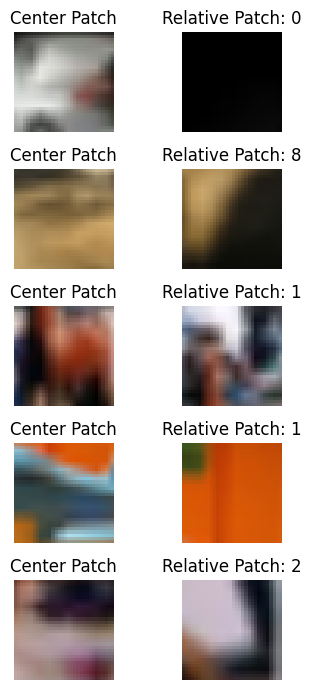

In [9]:
sample_images, sample_labels = next(iter(relative_patch_loader))
visualize_relative_patch(sample_images, sample_labels)

In [10]:
criterion = torch.nn.CrossEntropyLoss()

In [11]:
#Training the model

relative_patch_model.train()

for epoch in range(1, 11):
    correct = 0
    total = 0
    print ("Epoch %d" % epoch)
    for images, labels in relative_patch_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_relative.zero_grad()
        outputs = relative_patch_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_relative.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Training Accuracy: %d %%' % (100 * correct / total))
    print()

Epoch 1
Training Accuracy: 54 %

Epoch 2
Training Accuracy: 93 %

Epoch 3
Training Accuracy: 95 %

Epoch 4
Training Accuracy: 96 %

Epoch 5
Training Accuracy: 96 %

Epoch 6
Training Accuracy: 97 %

Epoch 7
Training Accuracy: 97 %

Epoch 8
Training Accuracy: 97 %

Epoch 9
Training Accuracy: 98 %

Epoch 10
Training Accuracy: 98 %



In [12]:
correct = 0
total = 0
for images, labels in relative_patch_test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = relative_patch_model(images)
  _, predicted = torch.max(outputs, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy: %d %%' % (100 * correct / total))

Test Accuracy: 97 %


In [13]:
downstream_model = PatchModel(num_classes=10).to(device)
downstream_model.backbone = relative_patch_model.backbone
optimizer_downstream = torch.optim.Adam(downstream_model.backbone.fc.parameters(), lr=0.0005)

In [14]:
relative_patch_dataset = RelativePatchDataset(train_dataset)
relative_patch_loader = DataLoader(relative_patch_dataset, batch_size=32, shuffle=True)

relative_patch_test_dataset = RelativePatchDataset(test_dataset)
relative_patch_test_loader = DataLoader(relative_patch_test_dataset, shuffle=True)

In [15]:
for epoch in range(1,11):  # Train for 10 epochs or as needed
    correct = 0
    total = 0
    print ("Epoch %d" % epoch)
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_downstream.zero_grad()
        outputs = downstream_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_downstream.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Training Accuracy Downstream: %d %%' % (100 * correct / total))
    print()

Epoch 1
Training Accuracy Downstream: 15 %

Epoch 2
Training Accuracy Downstream: 21 %

Epoch 3
Training Accuracy Downstream: 24 %

Epoch 4
Training Accuracy Downstream: 25 %

Epoch 5
Training Accuracy Downstream: 26 %

Epoch 6
Training Accuracy Downstream: 27 %

Epoch 7
Training Accuracy Downstream: 27 %

Epoch 8
Training Accuracy Downstream: 27 %

Epoch 9
Training Accuracy Downstream: 28 %

Epoch 10
Training Accuracy Downstream: 28 %



In [16]:
correct = 0
total = 0
for images, labels in relative_patch_test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = downstream_model(images)
  _, predicted = torch.max(outputs, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy Downstream: %d %%' % (100 * correct / total))

Test Accuracy Downstream: 85 %


In [17]:
relative_patch_model.eval()
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.h = []
        self.h.append(self.target_layer.register_backward_hook(self.save_gradients))

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, inputs, class_idx=None):
        outputs = self.model(inputs)
        if class_idx is None:
            class_idx = torch.argmax(outputs).item()
        self.model.zero_grad()
        one_hot = torch.zeros((1, outputs.size()[-1]), dtype=torch.float32).to(device)
        one_hot[0][class_idx] = 1
        outputs.backward(gradient=one_hot, retain_graph=True)
        activations = self.target_layer.forward(inputs)
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        grad_cam_map = torch.sum(weights * activations, dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=(inputs.size(2), inputs.size(3)), mode='bilinear', align_corners=False)
        for h in self.h:
            h.remove()
        return grad_cam_map


In [18]:
#Visualizing gradcam

def visualize_gradcam(img, mask):
    heatmap = (mask - mask.min()) / (mask.max() - mask.min())
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.transpose(heatmap, (1, 2, 0))
    heatmap = np.squeeze(heatmap)

    img = img * 0.5 + 0.5
    img = np.uint8(255 * img)
    img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.show()

In [19]:
#Visualising the original image

def visualize_image(img, mask):
    heatmap = (mask - mask.min()) / (mask.max() - mask.min())
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.transpose(heatmap, (1, 2, 0))
    heatmap = np.squeeze(heatmap)

    img = img * 0.5 + 0.5
    img = np.uint8(255 * img)
    img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.show()

/home/deekshant/.conda/envs/myenv/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


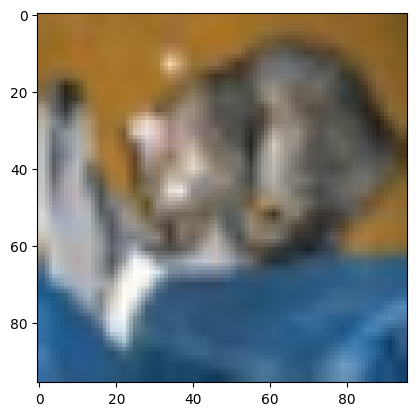

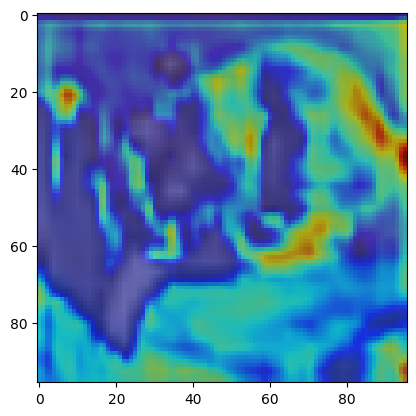

In [20]:
#Calling functions to randomly see the image and corresponding gradcam

sample_imgs, _ = next(iter(test_loader))
sample_img = sample_imgs[0].unsqueeze(0).to(device)

model_to_visualize = relative_patch_model
target_layer = model_to_visualize.backbone.conv1
grad_cam = GradCAM(model_to_visualize, target_layer)

heatmap = grad_cam(sample_img)
heatmap = heatmap.cpu().data.numpy()

visualize_image(sample_img.cpu().data.numpy()[0], heatmap[0])
visualize_gradcam(sample_img.cpu().data.numpy()[0], heatmap[0])